In [1]:
# Required Libraries
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer

# Download NLTK Resources
import nltk


In [2]:
nltk.download('stopwords')
nltk.download('wordnet')

# Set up Lemmatizer and Stopwords
lemmatizer = WordNetLemmatizer()
# Expanded list of stopwords including bigrams
SINGLE_STOPWORDS = set(stopwords.words('english')).union({
    # General fillers
    'get', 'got', 'like', 'know', 'one', 'thing', 'things', 'really', 'would', 'could', 'also',
    'even', 'make', 'much', 'many', 'say', 'said', 'well', 'still', 'dont', 'didnt', 'cant', 'im',
    'us', 'use', 'using', 'way', 'need', 'want', 'think', 'go', 'going', 'take', 'give', 'see', 'may',  
    # Contextless personal pronouns
    'i', 'you', 'he', 'she', 'we', 'they', 'me', 'him', 'her', 'them', 'your', 'my', 'our', 'their',   
    # Domain-generic words
    'agency', 'federal', 'employee', 'employees', 'government', 'position', 'job', 'jobs', 'office',
    'manager', 'supervisor', 'human', 'resource', 'work', 'working', 'time', 'day', 'year', 'month',
    'week', 'leave', 'pay', 'email', 'contact', 'title', 'context', 'question', 'concern', 'thank',
    'please', 'subreddit', 'moderator', 'bot', 'automatically', 'performed', 'message', 'compose',
    # Reddit/meta-specific terms
    'removed', 'deleted', 'post', 'thread', 'comment', 'reply', 'upvote', 'downvote',
})

BIGRAM_STOPWORDS={
    # Contractions (as bigrams often yield them)
    'you re', 'they re', 'we re', 'it s', 'that s', 'what s', 'who s', 'isn t', 'wasn t', 'aren t',
    'doesn t', 'don t', 'didn t', 'hasn t', 'haven t', 'hadn t', 'can t', 'couldn t', 'shouldn t',
    # Low-value system phrases from earlier outputs
    'provide context', 'context title', 'please contact', 'bot action', 'message compose',
    'fednews question', 'action performed', 'performed automatically', 'compose fednews',
    'moderator subreddit', 'subreddit message', 'contact moderator', 'question concern',
    'automatically please',
}

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/csgrads/shahr072/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/csgrads/shahr072/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
def clean_text(text):
    """
    Function to clean and preprocess the text.
    - Converts to lowercase.
    - Removes URLs and punctuation.
    - Lemmatizes first, then removes single word stopwords and bigram stopwords.
    """
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r"http\S+", "", text)
    # Remove punctuation
    text = re.sub(rf"[{re.escape(string.punctuation)}]", " ", text)
    # Tokenize the text
    tokens = text.split()
    # First, lemmatize all tokens
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Remove single-word stopwords
    filtered_tokens = [token for token in lemmatized_tokens if token not in SINGLE_STOPWORDS and len(token) > 2]

    # Now remove bigrams
    i = 0
    final_filtered_tokens = []
    bigrams_removed = 0
    while i < len(filtered_tokens):
        # Create bigram
        if i < len(filtered_tokens) - 1:
            bigram = f"{filtered_tokens[i]} {filtered_tokens[i+1]}"
            # Skip if it's in the bigram stopwords list
            if bigram in BIGRAM_STOPWORDS:
                bigrams_removed += 1
                i += 2  # Skip both words of the bigram
                continue

        # Add lemmatized token to final list
        final_filtered_tokens.append(filtered_tokens[i])
        i += 1  # Move to the next token
    if bigrams_removed>0: print(f"Removed {bigrams_removed} bigrams from the text.")
    return " ".join(final_filtered_tokens)

    #return " ".join(filtered_tokens)

In [4]:
from datetime import datetime  # Add this line to import datetime

# Load the posts and comments from JSONL files
def load_jsonl(file_path, text_fields):
    with open(file_path, 'r') as f:
        data = [json.loads(line) for line in f]
    rows = []
    for item in data:
        if any(item.get(field, '') in ['[removed]', '[deleted]'] for field in text_fields):
            continue
        text = ' '.join(item.get(field, '') for field in text_fields)
        timestamp = item.get('created_utc')
        if text and timestamp:
            dt = datetime.utcfromtimestamp(timestamp)
            week = dt.strftime('%Y-%U')  # Convert to week format (year-week)
            rows.append((week, clean_text(text)))
    return rows

In [5]:
# Example: Load data for posts and comments
# combining texts or relevant fields and adding a timestamp of week with that.
posts = load_jsonl('../2_months_data/filtered_posts.jsonl', ['title', 'selftext'])
#posts = load_jsonl('../2_months_data/filtered_comments.jsonl', ['body'])
#comments = load_jsonl('../2_months_data/filtered_comments.jsonl', ['body'])

/tmp/ipykernel_89599/1504836014.py:14: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  dt = datetime.utcfromtimestamp(timestamp)


In [6]:
# print sample of posts
print("Sample posts:")
for i in range(6):
    print(posts[i])
print(len(posts))

Sample posts:
('2025-00', 'connecticut fed health insurance pick remote new health insurance pick old wife asthma looking high deductible plan reason tell choose far seems aetna blue cross best option')
('2025-00', 'someone explain compare')
('2025-00', 'advice needed class bit comparison explanation supply tech routinely weekly stock order hospital clinic external cbocs maintain inventory inventory editing predicting usage normal duty supply tech recently asked management department looking classification burnt workload told relative type repetitive considering filing grievance union requesting opm audit wanted opinion two inventory report weekly update inventory receivables gs9 responsible clinic try union start search nuclear request audit request opm audit doe anyone start')
('2025-00', 'vha gsa remote currently remote vha offered two promotion vha gsa remote similar difference since vha special salary rate step lower gsa i’m trying figure there’s reason prefer here’s thinking feel

In [7]:
# grouping the posts/comments by week
combined_by_week = defaultdict(list)
for week, text in posts:
    combined_by_week[week].append(text)

In [8]:
# print sample of combined_by_week
print("Sample combined_by_week:")
for week, texts in list(combined_by_week.items())[:5]:
    print(week, texts[:2])  # Print the first two texts for each week

Sample combined_by_week:
2025-00 ['connecticut fed health insurance pick remote new health insurance pick old wife asthma looking high deductible plan reason tell choose far seems aetna blue cross best option', 'someone explain compare']
2025-01 ['significance accruing hour last ppd noticed accrued hour instead ppd wondering accrue additional hour tried look opm site reasoning isn’t specified', 'optimize scheduling trip another state part involve scheduling interview individual last hour fly two hour state authority schedule negotiate date interview held thinking matter compensated travel pours outside tod prefer avoid booking hotel back home best schedule interview least near noon fly earlier account potential flight delay']
2025-02 ['significance coming probation period nonbargaining appeal right additional protection doe completing probation period offer nonbargaining unit', 'talk fed losing aws discussion fed losing schedule fed hour period 10th chopping block figured ask thanks ad

topic modeling using gensim for unigram

In [ ]:
import gensim
from gensim import corpora
from gensim.models import LdaModel

week = '2025-00'  # Example week to visualize
lda_results = {}
docs = combined_by_week[week] # Get the posts for the specified week
# Tokenize the documents
tokenized_docs = [text.split() for text in docs]
# Then use tokenized_docs in the corpora.Dictionary and doc2bow
dictionary = corpora.Dictionary(tokenized_docs)
# Creating document-term matrix
doc_term_matrix = [dictionary.doc2bow(text) for text in tokenized_docs]
# Apply LDA using Gensim
# The following lines will feed the model to get 10 topics for each week and then explain that topic with top 10 words.
lda_model = LdaModel(doc_term_matrix, num_topics=7, id2word=dictionary, passes=10)
# Store the LDA result for each week
lda_results[week] = lda_model.print_topics(num_words=10)  # Print top 5 words for each topic

topic modeling using gensim for bigram

In [9]:
import gensim
from gensim import corpora
from gensim.models import Phrases
from gensim.models import LdaModel

# Assuming docs is your list of posts (each post being a string of text)
week = '2025-00'  # Example week to visualize
lda_results = {}
docs = combined_by_week[week] # Get the posts for the specified week
# Tokenize the documents (this could also be done using nltk or other libraries)
tokenized_docs = [text.split() for text in docs]
# Create bigrams using Gensim's Phrases model
bigram_model = Phrases(tokenized_docs, min_count=5, threshold=100)  # min_count and threshold control how bigrams are formed
bigram_docs = [bigram_model[doc] for doc in tokenized_docs]
# Create the dictionary and corpus for LDA
dictionary = corpora.Dictionary(bigram_docs)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in bigram_docs]
# Apply LDA using Gensim
lda_model = LdaModel(doc_term_matrix, num_topics=5, id2word=dictionary, passes=10)
# Store the LDA result for the week
lda_results = lda_model.print_topics(num_words=10)  # Print top 10 words for each topic
# Print the topics
for topic in lda_results:
    print(topic)

(0, '0.006*"people" + 0.005*"love" + 0.005*"worker" + 0.005*"award" + 0.005*"hour" + 0.005*"new" + 0.004*"anyone" + 0.004*"remote" + 0.004*"it’s" + 0.004*"thanks"')
(1, '0.009*"i’m" + 0.006*"due" + 0.005*"back" + 0.005*"people" + 0.005*"bos" + 0.005*"step" + 0.004*"fed" + 0.004*"anyone" + 0.004*"clerk" + 0.004*"plan"')
(2, '0.011*"new" + 0.011*"insurance" + 0.009*"benefit" + 0.007*"start" + 0.007*"health" + 0.007*"coverage" + 0.006*"2025" + 0.006*"i’m" + 0.006*"date" + 0.006*"period"')
(3, '0.012*"anyone" + 0.010*"i’m" + 0.010*"doe" + 0.007*"saving" + 0.006*"opm" + 0.005*"hsa" + 0.005*"period" + 0.005*"something" + 0.005*"info" + 0.005*"account"')
(4, '0.009*"travel" + 0.006*"insurance" + 0.006*"plan" + 0.006*"period" + 0.005*"hour" + 0.005*"doe" + 0.005*"required" + 0.005*"home" + 0.005*"scenario" + 0.005*"2025"')


In [10]:
lda_model.show_topics(num_words=10)

[(0,
  '0.006*"people" + 0.005*"love" + 0.005*"worker" + 0.005*"award" + 0.005*"hour" + 0.005*"new" + 0.004*"anyone" + 0.004*"remote" + 0.004*"it’s" + 0.004*"thanks"'),
 (1,
  '0.009*"i’m" + 0.006*"due" + 0.005*"back" + 0.005*"people" + 0.005*"bos" + 0.005*"step" + 0.004*"fed" + 0.004*"anyone" + 0.004*"clerk" + 0.004*"plan"'),
 (2,
  '0.011*"new" + 0.011*"insurance" + 0.009*"benefit" + 0.007*"start" + 0.007*"health" + 0.007*"coverage" + 0.006*"2025" + 0.006*"i’m" + 0.006*"date" + 0.006*"period"'),
 (3,
  '0.012*"anyone" + 0.010*"i’m" + 0.010*"doe" + 0.007*"saving" + 0.006*"opm" + 0.005*"hsa" + 0.005*"period" + 0.005*"something" + 0.005*"info" + 0.005*"account"'),
 (4,
  '0.009*"travel" + 0.006*"insurance" + 0.006*"plan" + 0.006*"period" + 0.005*"hour" + 0.005*"doe" + 0.005*"required" + 0.005*"home" + 0.005*"scenario" + 0.005*"2025"')]

In [ ]:
from gensim.models import CoherenceModel
# Calculate coherence for the LDA model
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_docs, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model_lda.get_coherence()
print(f"Coherence Score: {coherence_score}")

/home/csgrads/shahr072/anaconda3/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=2197451) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/home/csgrads/shahr072/anaconda3/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=2197451) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


/home/csgrads/shahr072/anaconda3/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=2197451) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/home/csgrads/shahr072/anaconda3/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=2197451) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/home/csgrads/shahr072/anaconda3/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=2197451) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/home/csgrads/shahr072/anaconda3/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=2197451) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/home/csgrads/shahr072/anaconda3/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (

Coherence Score: 0.26899298107137654


In [ ]:
# Print the LDA topics for each week
for week, topics in lda_results.items():
    if week == '2025-00':
        print(f"Week: {week}")
        for topic in topics:
            print(f"  {topic}")
        print("\n")

Week: 2025-00
  (0, '0.008*"i’m" + 0.007*"sock" + 0.006*"fehb" + 0.006*"due" + 0.006*"district" + 0.006*"compression" + 0.006*"issue" + 0.006*"steward" + 0.006*"condition" + 0.006*"direct"')
  (1, '0.019*"qsi" + 0.017*"bonus" + 0.013*"step" + 0.011*"open" + 0.009*"told" + 0.009*"period" + 0.007*"better" + 0.007*"health" + 0.006*"insurance" + 0.006*"cash"')
  (2, '0.012*"dental" + 0.012*"start" + 0.011*"new" + 0.009*"i’m" + 0.009*"benefit" + 0.009*"bcbs" + 0.009*"insurance" + 0.009*"currently" + 0.008*"2025" + 0.007*"service"')
  (3, '0.010*"union" + 0.009*"people" + 0.009*"anyone" + 0.007*"annual" + 0.006*"travel" + 0.005*"someone" + 0.005*"anything" + 0.005*"inventory" + 0.005*"find" + 0.005*"europe"')
  (4, '0.013*"hour" + 0.011*"end" + 0.009*"i’m" + 0.009*"system" + 0.009*"medicare" + 0.009*"insurance" + 0.009*"coverage" + 0.008*"plan" + 0.007*"organization" + 0.007*"holiday"')
  (5, '0.009*"health" + 0.009*"standard" + 0.008*"insurance" + 0.008*"new" + 0.006*"lab" + 0.006*"hire" + 

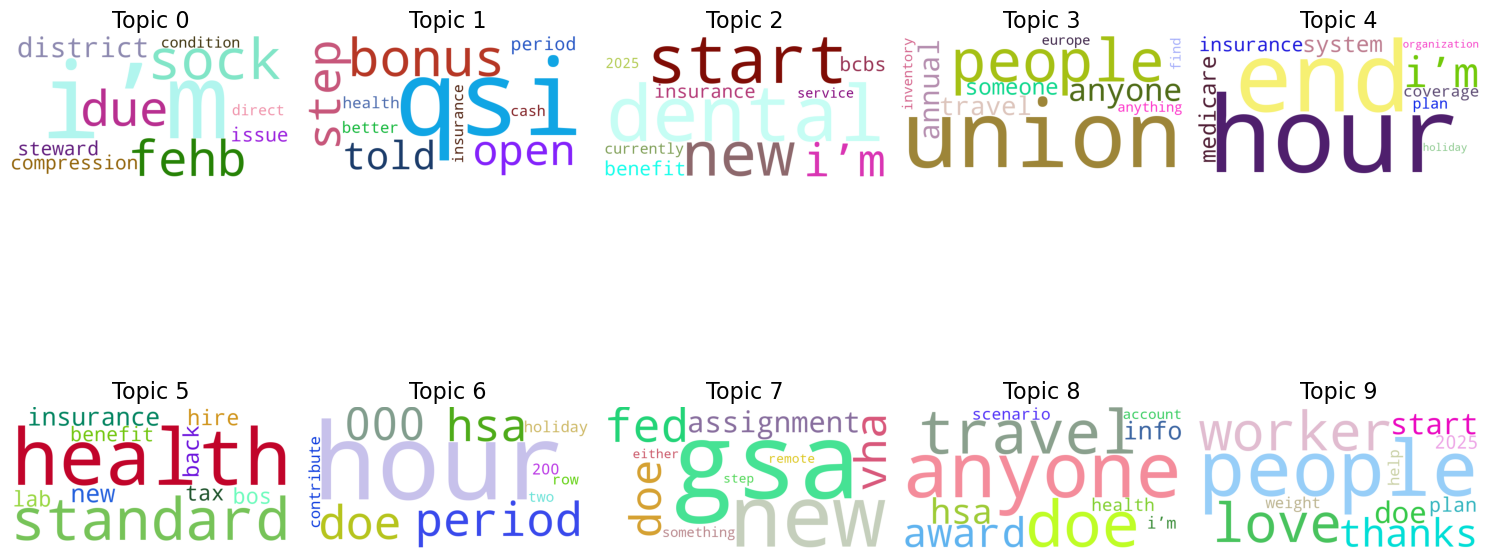

In [33]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors



# Function to parse topic strings into dictionaries
def parse_topic_string(topic_string):
    word_freq = {}
    for item in topic_string.split(" + "):
        weight, word = item.split("*")
        word_freq[word.strip('"')] = float(weight)
    return word_freq


# Adjust the grid size to fit all topics (2 rows, 5 columns for 10 topics)
fig, axes = plt.subplots(2, 5, figsize=(15, 10), sharex=True, sharey=True)

cloud = WordCloud(
    background_color='white',
    width=800,
    height=400,
    max_words=100,
    colormap='viridis',
    color_func=lambda *args, **kwargs: mcolors.to_hex(np.random.rand(3)),
    stopwords=STOPWORDS.union(SINGLE_STOPWORDS),
)

topics = lda_results['2025-00']
# # Create a color palette
# palette = sns.color_palette("viridis", len(topics))
# # Create a color map
# cmap = mcolors.ListedColormap(palette)
# # Create a color map for the word cloud
# # Create a color map for the word cloud
# # Create a color map for the word cloud
for i, (topic_id, topic_string) in enumerate(topics):
    ax = axes[i // 5, i % 5]  # Arrange subplots in a 2x5 grid
    
    topic_words = parse_topic_string(topic_string)
    cloud.generate_from_frequencies(topic_words, max_font_size=300)

    ax.imshow(cloud)  # Use the specific subplot axis
    ax.set_title(f'Topic {topic_id}', fontdict=dict(size=16))
    ax.axis('off')  # Turn off axis for the subplot

    # plt.gca().imshow(cloud)
    # plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    # plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()


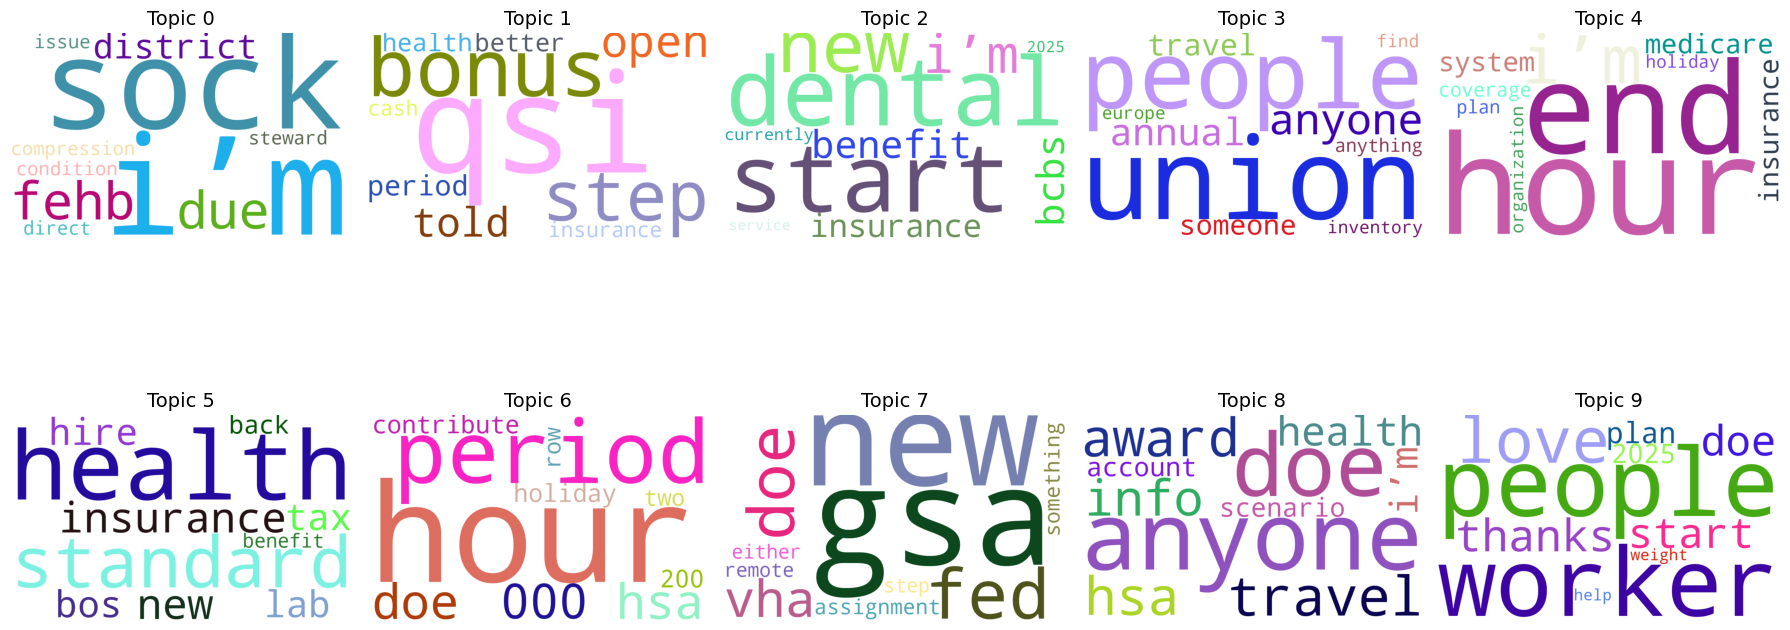

In [39]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
import numpy as np

# Function to parse topic strings into dictionaries
def parse_topic_string(topic_string):
    word_freq = {}
    for item in topic_string.split(" + "):
        weight, word = item.split("*")
        word_freq[word.strip('"')] = float(weight)
    return word_freq

# Adjust the grid size to fit all topics (2 rows, 5 columns for 10 topics)
fig, axes = plt.subplots(2, 5, figsize=(18, 10), sharex=True, sharey=True)  # Reduced figure size slightly

cloud = WordCloud(
    background_color='white',
    width=1000,  # High resolution for word clouds
    height=600,
    max_words=100,
    colormap='viridis',
    color_func=lambda *args, **kwargs: mcolors.to_hex(np.random.rand(3)),
    stopwords=STOPWORDS,
)

topics = lda_results['2025-00']

for i, (topic_id, topic_string) in enumerate(topics):
    ax = axes[i // 5, i % 5]  # Arrange subplots in a 2x5 grid
    
    topic_words = parse_topic_string(topic_string)
    cloud.generate_from_frequencies(topic_words, max_font_size=400)

    ax.imshow(cloud)  # Use the specific subplot axis
    ax.set_title(f'Topic {topic_id}', fontdict=dict(size=14))  # Title font size
    ax.axis('off')  # Turn off axis for the subplot

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.2)  # Reduced horizontal and vertical spacing
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ensure layout fits well
plt.show()